<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/gan_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/
#!rm -r outputs


import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import numpy as np
import os
from tensorflow.keras import layers
import time
import cv2
from IPython import display


/content/drive/MyDrive


In [2]:

train_images_cartoon = []
small_images_cartoon = []

try:
  train_images_cartoon = np.load("npfilet.npy")
  small_images_cartoon = np.load("npfiles.npy")
except:
  %cd /content
  os.system("git clone https://github.com/dercodeKoenig/cartoon-faces.git")
  train_images_cartoon = []
  small_images_cartoon = []
  z=0
  total = len(os.listdir("cartoon-faces"))
  max=512*100
  files = os.listdir("cartoon-faces")
  while(True):
    if(z>=max):
      break
    print("\r" + str(z) + " / " + str(51200),end="")
    try:
      img = cv2.imread("cartoon-faces/"+files[z])

      img1 = img.copy()
      img3 = cv2.resize(img1, (64,64))
      img3 = cv2.blur(img3,(7,7))
      
    
      Z = img3.reshape((-1,3))
      # convert to np.float32
      Z = np.float32(Z)
      # define criteria, number of clusters(K) and apply kmeans()
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
      K = 4
      ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
      # Now convert back into uint8, and make original image
      center = np.uint8(center)
      res = center[label.flatten()]
      res2 = res.reshape((img3.shape))

      small_images_cartoon.append(res2)


      img1 = img.copy()
      img2 = cv2.resize(img1, (64,64))
      train_images_cartoon.append(img2)
    
    except:
      print("error: ")
      try:
        print(" cartoon-faces/"+files[z])
      except:
        pass
      max+=1

    z+=1
  print("")

  train_images_cartoon = np.array(train_images_cartoon,dtype=object)
  train_images_cartoon = train_images_cartoon.reshape(train_images_cartoon.shape[0], 64, 64, 3).astype('float32')
  train_images_cartoon = (train_images_cartoon - 127.5) / 127.5  # Normalize the images to [-1, 1]

  small_images_cartoon = np.array(small_images_cartoon,dtype=object)
  small_images_cartoon = small_images_cartoon.reshape(small_images_cartoon.shape[0], 64, 64, 3).astype('float32')
  small_images_cartoon = (small_images_cartoon - 127.5) / 127.5  # Normalize the images to [-1, 1]

  %cd /content/drive/MyDrive/
  np.save("npfilet", train_images_cartoon)
  np.save("npfiles", small_images_cartoon)

print("")


In [5]:
small_images_cartoon = np.array(tf.keras.layers.experimental.preprocessing.RandomZoom((0,0.4),fill_mode='constant',fill_value=1)(small_images_cartoon))
  
test_img = small_images_cartoon[0:20]

print(train_images_cartoon.shape)
train_images_cartoon1=train_images_cartoon[0:int(1*train_images_cartoon.shape[0]/4)]
train_images_cartoon2=train_images_cartoon[int(1*train_images_cartoon.shape[0]/4):int(2*train_images_cartoon.shape[0]/4)]
train_images_cartoon3=train_images_cartoon[int(2*train_images_cartoon.shape[0]/4):int(3*train_images_cartoon.shape[0]/4)]
train_images_cartoon4=train_images_cartoon[int(3*train_images_cartoon.shape[0]/4):int(4*train_images_cartoon.shape[0]/4)]
print(train_images_cartoon1.shape)
print(train_images_cartoon2.shape)
print(train_images_cartoon3.shape)
print(train_images_cartoon4.shape)





print(small_images_cartoon.shape)
small_images_cartoon1=small_images_cartoon[0:int(1*small_images_cartoon.shape[0]/4)]
small_images_cartoon2=small_images_cartoon[int(1*small_images_cartoon.shape[0]/4):int(2*small_images_cartoon.shape[0]/4)]
small_images_cartoon3=small_images_cartoon[int(2*small_images_cartoon.shape[0]/4):int(3*small_images_cartoon.shape[0]/4)]
small_images_cartoon4=small_images_cartoon[int(3*small_images_cartoon.shape[0]/4):int(4*small_images_cartoon.shape[0]/4)]
print(small_images_cartoon1.shape)
print(small_images_cartoon2.shape)
print(small_images_cartoon3.shape)
print(small_images_cartoon4.shape)






print("All devices: ", tf.config.list_logical_devices('TPU'))
BATCH_SIZE_PER_REPLICA = 16
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 8 #8TPUs

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
except:
  strategy = tf.distribute.MirroredStrategy()

train_images_cartoon1 = tf.data.Dataset.from_tensor_slices((train_images_cartoon1)).batch(GLOBAL_BATCH_SIZE)  
train_images_cartoon2 = tf.data.Dataset.from_tensor_slices((train_images_cartoon2)).batch(GLOBAL_BATCH_SIZE) 
train_images_cartoon3 = tf.data.Dataset.from_tensor_slices((train_images_cartoon3)).batch(GLOBAL_BATCH_SIZE) 
train_images_cartoon4 = tf.data.Dataset.from_tensor_slices((train_images_cartoon4)).batch(GLOBAL_BATCH_SIZE) 
train_images_cartoon1 = strategy.experimental_distribute_dataset(train_images_cartoon1)
train_images_cartoon2 = strategy.experimental_distribute_dataset(train_images_cartoon2)
train_images_cartoon3 = strategy.experimental_distribute_dataset(train_images_cartoon3)
train_images_cartoon4 = strategy.experimental_distribute_dataset(train_images_cartoon4)


small_images_cartoon1 = tf.data.Dataset.from_tensor_slices((small_images_cartoon1)).batch(GLOBAL_BATCH_SIZE)  
small_images_cartoon2 = tf.data.Dataset.from_tensor_slices((small_images_cartoon2)).batch(GLOBAL_BATCH_SIZE) 
small_images_cartoon3 = tf.data.Dataset.from_tensor_slices((small_images_cartoon3)).batch(GLOBAL_BATCH_SIZE) 
small_images_cartoon4 = tf.data.Dataset.from_tensor_slices((small_images_cartoon4)).batch(GLOBAL_BATCH_SIZE) 
small_images_cartoon1 = strategy.experimental_distribute_dataset(small_images_cartoon1)
small_images_cartoon2 = strategy.experimental_distribute_dataset(small_images_cartoon2)
small_images_cartoon3 = strategy.experimental_distribute_dataset(small_images_cartoon3)
small_images_cartoon4 = strategy.experimental_distribute_dataset(small_images_cartoon4)



(51200, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
(51200, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
(12800, 64, 64, 3)
All devices:  []
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64,64,3)))
    
    model.add(layers.Conv2D(128, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(32, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(32, 5))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(8*8*16, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)
    
    model.add(layers.Reshape((8,8,16)))
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)



    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)



    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)



    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    
    model.add(layers.Conv2DTranspose(128, (5, 5),padding="same", strides=(2, 2), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

  
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    
    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2D(128, 5,padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(3,5,padding="same",strides=(1, 1), activation='tanh', use_bias=False))


    return model


def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(64,64,3)))
    
    print(model.output_shape)

    model.add(layers.Conv2D(16, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Flatten())


    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Dense(1,activation="sigmoid"))

    return model


In [7]:
with strategy.scope():
  discriminator_cartoon = make_discriminator_model()
  generator = make_generator_model()

  discriminator_cartoon.summary()
  generator.summary()


(None, 64, 64, 3)
(None, 60, 60, 16)
(None, 56, 56, 32)
(None, 52, 52, 128)
(None, 48, 48, 128)
(None, 44, 44, 128)
(None, 40, 40, 128)
(None, 256)
(None, 60, 60, 128)
(None, 56, 56, 32)
(None, 52, 52, 32)
(None, 1024)
(None, 8, 8, 16)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 128)
(None, 64, 64, 128)
(None, 64, 64, 128)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 60, 16)        0         
________________________________________________

In [8]:
with strategy.scope():
# This method returns a helper function to compute cross entropy loss
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False,reduction=tf.keras.losses.Reduction.NONE)

  def discriminator_cartoon_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    #print("disc_loss:",total_loss)
    return  tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)


  def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)


  def apply_blur(img):
    blur = _gaussian_kernel(17, 30, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return img


  def generator_loss(fake_output,norm,genr):

    norm=apply_blur(norm)
    genr=apply_blur(genr)
    total_loss=tf.nn.compute_average_loss(((norm-genr)*(norm-genr)))*0.3+0.7*tf.nn.compute_average_loss((cross_entropy(tf.ones_like(fake_output), fake_output)))
   # print("gen_loss:",total_loss)
    return  (total_loss)

  generator_optimizer = tf.keras.optimizers.Adam(0.000003)
  discriminator_cartoon_optimizer = tf.keras.optimizers.Adam(0.00001)

  @tf.function
  def train_step_cartoon(cartoons,dataset_seed):

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_cartoon_tape :
        
        generated_images = generator(dataset_seed, training=True)

        real_output_cartoon = discriminator_cartoon(cartoons, training=True)

        fake_output_cartoon = discriminator_cartoon(generated_images, training=True)

        gen_loss = generator_loss(fake_output_cartoon,dataset_seed,generated_images)
        
        disc_cartoon_loss = discriminator_cartoon_loss(real_output_cartoon, fake_output_cartoon)
      
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator_cartoon = disc_cartoon_tape.gradient(disc_cartoon_loss, discriminator_cartoon.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      
      discriminator_cartoon_optimizer.apply_gradients(zip(gradients_of_discriminator_cartoon, discriminator_cartoon.trainable_variables))
      
        
  

def train(dataset_seed,dataset_cartoon, epochs):
  for epoch in range(epochs):
    start = time.time()
    ii=0
    for image_batch in dataset_cartoon:
      for seed_batch in dataset_seed:
        ii+=1
        print("\r" + str(ii),end="")
        strategy.run(train_step_cartoon,args=(image_batch,seed_batch,))

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("save chkp")
    generator.save_weights('gen_weights.h5', overwrite=True)
    discriminator_cartoon.save_weights('disc_weights.h5', overwrite=True)
    generate_images(generator,test_img)

starttime = time.process_time()


def generate_images(model, test_input):    
  predictions = model(test_input,training=False)
  predictions = np.array(predictions)
    
#  test_input = apply_blur(test_input)
  test_input = np.array(test_input,dtype= 'float32')
  test_input = (test_input+1)*127.5

#  predictions=apply_blur(predictions)

  generated_images = np.array(predictions,dtype= 'float32')
#  print(generated_images)
  generated_images = (generated_images+1)*127.5
  cz=0
  cz2 =0
  heighest = 0
  while(True):
      heighest +=1
      if(os.path.exists("outputs/0/"+str(heighest)+".jpg")==False):
        break

  fig = plt.figure(figsize=(20,10))
  for i in generated_images:
    plt.subplot(4, 10, cz2+1)
    plt.imshow(np.array(cv2.cvtColor(test_input[cz], cv2.COLOR_BGR2RGB),dtype= 'int32'))
    plt.subplot(4, 10, cz2+2)
    plt.imshow(np.array(cv2.cvtColor(i, cv2.COLOR_BGR2RGB),dtype= 'int32'))
    plt.axis('off')
    cz+=1
    cz2+=2
  
  display.clear_output(wait=True)
  plt.show()
  global starttime
  end = time.process_time()
  print(end - starttime)
  starttime = time.process_time()

try:
  generator.load_weights('gen_weights.h5')
  discriminator_cartoon.load_weights('disc_weights.h5')
except:
  print("no model stored")


In [ ]:
for i in range(10000):  
  train(small_images_cartoon2,train_images_cartoon2, 1)
  train(small_images_cartoon4,train_images_cartoon4, 1)
  train(small_images_cartoon3,train_images_cartoon3, 1)  
  train(small_images_cartoon1,train_images_cartoon1, 1)

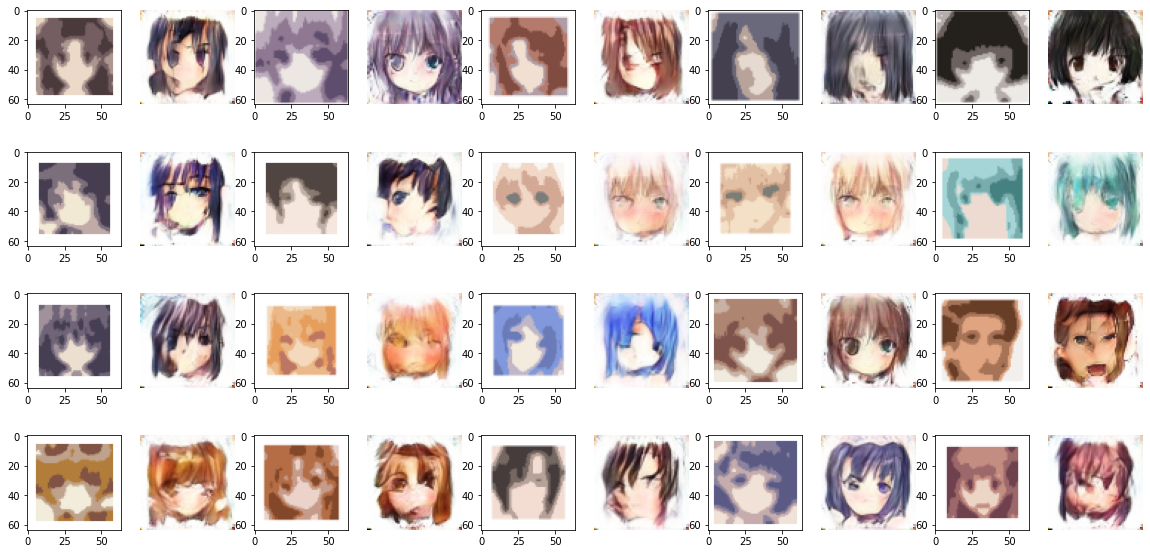

14.487925069999996


In [9]:
generate_images(generator,test_img)

In [ ]:
try:
  generator.load_weights('gen_weights.h5')
  discriminator_cartoon.load_weights('disc_weights.h5')
except:
  print("no model stored")

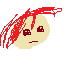

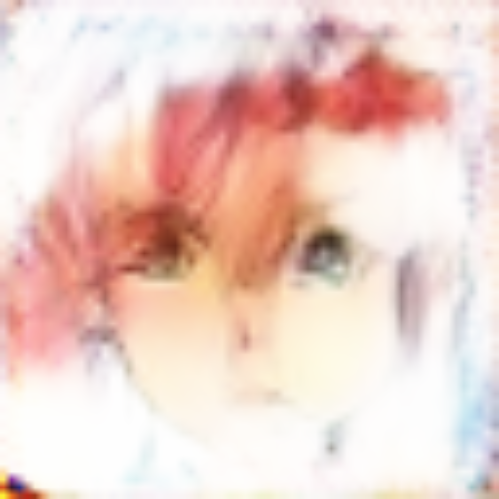

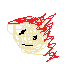

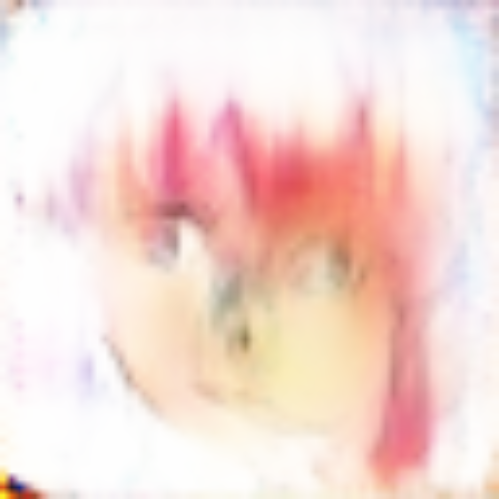

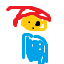

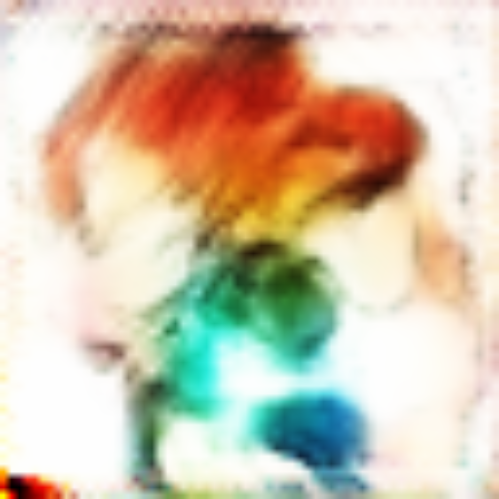

In [5]:
from google.colab.patches import cv2_imshow

def generate_image(model, filename):    
  small_images_cartoon=[]
  img = cv2.imread(filename)
  img3 = cv2.resize(img, (64,64))
  img3 = cv2.blur(img3,(7,7))
  small_images_cartoon.append(img3)
  small_images_cartoon = np.array(small_images_cartoon,dtype=object)
  small_images_cartoon = small_images_cartoon.reshape(small_images_cartoon.shape[0], 64, 64, 3).astype('float32')
  small_images_cartoon = (small_images_cartoon - 127.5) / 127.5  # Normalize the images to [-1, 1]

  predictions = model(small_images_cartoon,training=False)
  generated_images = np.array(predictions,dtype= 'float32')
  generated_images = (generated_images+1)*127.5

  img2=cv2.resize(generated_images[0],(499,499))
  cv2_imshow(img)
  cv2_imshow(img2)

generate_image(generator,"Unbenannt3.png")
generate_image(generator,"Unbenannt2.png")
generate_image(generator,"Unbenannt.png")